In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import sys
sys.path.append('C:\\Users\\Peace\\Documents\\Project\\Final\\')
import features

D:\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# %%
# Loading train and test data

path = "C:\\Users\\Peace\\Documents\\Project\\Final\\"
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
print(train.info(memory_usage='deep')) # Using memory_usage parameter to include the size of object datatype columns too

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149999 entries, 0 to 149998
Data columns (total 6 columns):
id              149999 non-null int64
qid1            149999 non-null int64
qid2            149999 non-null int64
question1       149999 non-null object
question2       149999 non-null object
is_duplicate    149999 non-null int64
dtypes: int64(4), object(2)
memory usage: 38.3 MB
None


In [3]:
# %%
# Dropping id, qid1, qid2 columns - plays no role

train = train.loc[:, ['question1', 'question2', 'is_duplicate']]
print(train.head())

                                           question1  \
0  What is the step by step guide to invest in sh...   
1  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2  How can I increase the speed of my internet co...   
3  Why am I mentally very lonely? How can I solve...   
4  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  


In [4]:
# %%
# Finding if there are any missing values in the data

print(train.isnull().sum())
print(train[train.question2.isnull()]) # Index 105780 has a missing value, so let us remove this row from the data
# Dropping row with index 105780 and again checking if the file has any missing value in it
train = train.drop(105780)
print(train.isnull().sum())

question1       0
question2       0
is_duplicate    0
dtype: int64
Empty DataFrame
Columns: [question1, question2, is_duplicate]
Index: []
question1       0
question2       0
is_duplicate    0
dtype: int64


In [5]:
# %%
# Making question columns to lowercase
train.question1 = train.question1.str.lower()
train.question2 = train.question2.str.lower()

In [6]:
# %%
# Creating features of the train data and storing them in the x_train DataFrame

x_train = pd.DataFrame()
x_train["X1"] = train.apply(features.word_match_share, axis=1, raw=True)
x_train["X2"] = train.apply(features.tfidf_word_match_share, axis=1, raw=True)
x_train["X3"] = pd.DataFrame(features.common_words_count(train))
X4, X5 = features.fuzz_sort_set(train)
x_train["X4"] = X4
x_train["X5"] = X5

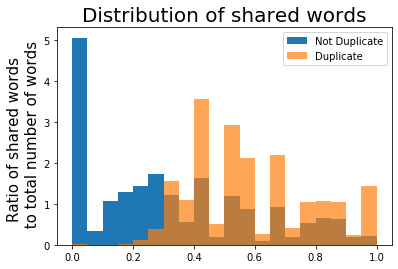

In [7]:
# %%
# Inferences from the first feature - Word Match Share 

plt.hist(x_train.X1[train['is_duplicate'] == 0], bins=20, density=True, label='Not Duplicate')
plt.hist(x_train.X1[train['is_duplicate'] == 1], bins=20, density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Distribution of shared words', fontsize=20)
plt.ylabel('Ratio of shared words \n to total number of words', fontsize=15)
plt.show()

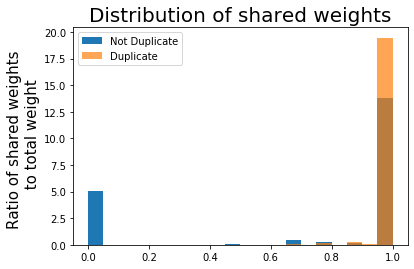

In [8]:
# Inference from the above plot: Most of the questions (excluding the overlapping ones) 
# can be classified as duplicate and non-duplicate as confirmed from the graph.

# %%
# Inferences from the second feature - TF-IDF Word Match Share 

plt.hist(x_train.X2[train['is_duplicate'] == 0], bins=20, density=True, label='Not Duplicate')
plt.hist(x_train.X2[train['is_duplicate'] == 1], bins=20, density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Distribution of shared weights', fontsize=20)
plt.ylabel('Ratio of shared weights \n to total weight', fontsize=15)
plt.show()

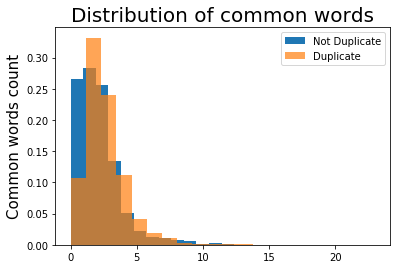

In [9]:
# Even this feature is helpful in classifying either duplicate or not

# %%
# Inferences from the third feature - Common words count

plt.hist(x_train.X3[train['is_duplicate'] == 0], bins=20, density=True, label='Not Duplicate')
plt.hist(x_train.X3[train['is_duplicate'] == 1], bins=20, density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Distribution of common words', fontsize=20)
plt.ylabel('Common words count', fontsize=15)
plt.show()

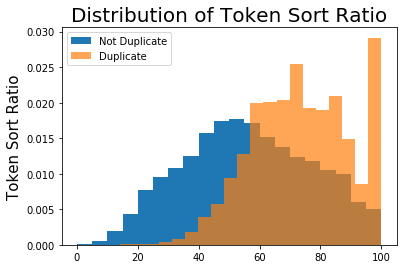

In [10]:
# This feature may be slightly helpul as most of the data is overlapping

# %%
# Inferences from the third feature - Token Sort Ratio

plt.hist(x_train.X4[train['is_duplicate'] == 0], bins=20, density=True, label='Not Duplicate')
plt.hist(x_train.X4[train['is_duplicate'] == 1], bins=20, density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Distribution of Token Sort Ratio', fontsize=20)
plt.ylabel('Token Sort Ratio', fontsize=15)
plt.show()

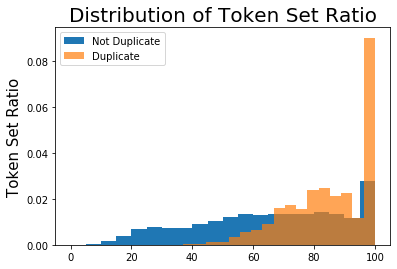

In [11]:
# This one is quite helpful as a good amount of data is not overlapping

# %%
# Inferences from the third feature - Token Set Ratio

plt.hist(x_train.X5[train['is_duplicate'] == 0], bins=20, density=True, label='Not Duplicate')
plt.hist(x_train.X5[train['is_duplicate'] == 1], bins=20, density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Distribution of Token Set Ratio', fontsize=20)
plt.ylabel('Token Set Ratio', fontsize=15)
plt.show()

In [12]:
# Perfect, even this feature provides good insights.

# %%
# Analyzing these features based on ROC AUC metric

print('          Original AUC:', roc_auc_score(train['is_duplicate'], x_train.X1))
print('             TFIDF AUC:', roc_auc_score(train['is_duplicate'], x_train.X2.fillna(0)))
print('Common Word Counts AUC:', roc_auc_score(train['is_duplicate'], x_train.X3))
print('  Token Sort Ratio AUC:', roc_auc_score(train['is_duplicate'], x_train.X4))
print('   Token Set Ratio AUC:', roc_auc_score(train['is_duplicate'], x_train.X5))

          Original AUC: 0.7807432799256717
             TFIDF AUC: 0.6556502569329044
Common Word Counts AUC: 0.7266631941572916
  Token Sort Ratio AUC: 0.7443284986667843
   Token Set Ratio AUC: 0.7446347145677159


In [13]:
# Inference - Feature importance is shown below:
# X1 > X5 > X4 > X3 > X2

# %%

# Splitting data in train and validation set for model building
# Considering 20% data as validation data

X_t, X_v, y_t, y_v = train_test_split(x_train, train['is_duplicate'].values,
                                      test_size=0.2, random_state=42)

In [20]:
# %%
# Model Building - XGBoost

# Setting parameters
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 2

d_train = xgb.DMatrix(X_t, label=y_t)
d_valid = xgb.DMatrix(X_v, label=y_v)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

In [21]:
# Training the model
XGboostModel = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.68636	valid-logloss:0.68627
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.63032	valid-logloss:0.63027
[20]	train-logloss:0.59079	valid-logloss:0.59081
[30]	train-logloss:0.56176	valid-logloss:0.56180
[40]	train-logloss:0.53999	valid-logloss:0.54002
[50]	train-logloss:0.52332	valid-logloss:0.52339
[60]	train-logloss:0.51055	valid-logloss:0.51068
[70]	train-logloss:0.50054	valid-logloss:0.50071
[80]	train-logloss:0.49274	valid-logloss:0.49282
[90]	train-logloss:0.48650	valid-logloss:0.48659
[100]	train-logloss:0.48145	valid-logloss:0.48164
[110]	train-logloss:0.47745	valid-logloss:0.47768
[120]	train-logloss:0.47439	valid-logloss:0.47451
[130]	train-logloss:0.47178	valid-logloss:0.47195
[140]	train-logloss:0.46976	valid-logloss:0.46991
[150]	train-logloss:0.46804	valid-logloss:0.46825
[160]	train-logloss:0.46665	valid-logloss:0.46686
[170]	trai

In [16]:
# Saving the model parameters in an external file
joblib.dump(XGboostModel, path + "XGboostModel.sav")

['C:\\Users\\Peace\\Documents\\Project\\Final\\XGboostModel.sav']

In [17]:
# %%
# Model Building - LGBoost

# Setting parameters
params = {}
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'    
params['eta'] = 0.02
params['max_depth'] = 2

lgtrain = lgb.Dataset(X_t, label=y_t)
lgval = lgb.Dataset(X_v, label=y_v)

LGboostModel = lgb.train(params, lgtrain, 400, valid_sets=[lgtrain, lgval], early_stopping_rounds=50, verbose_eval=10)

Training until validation scores don't improve for 50 rounds
[10]	training's binary_logloss: 0.609239	valid_1's binary_logloss: 0.609748
[20]	training's binary_logloss: 0.573238	valid_1's binary_logloss: 0.573629
[30]	training's binary_logloss: 0.547012	valid_1's binary_logloss: 0.54734
[40]	training's binary_logloss: 0.527572	valid_1's binary_logloss: 0.527857
[50]	training's binary_logloss: 0.512983	valid_1's binary_logloss: 0.51326
[60]	training's binary_logloss: 0.501972	valid_1's binary_logloss: 0.502231
[70]	training's binary_logloss: 0.493447	valid_1's binary_logloss: 0.493677
[80]	training's binary_logloss: 0.486823	valid_1's binary_logloss: 0.487029
[90]	training's binary_logloss: 0.481617	valid_1's binary_logloss: 0.481812
[100]	training's binary_logloss: 0.477504	valid_1's binary_logloss: 0.477692
[110]	training's binary_logloss: 0.474327	valid_1's binary_logloss: 0.474504
[120]	training's binary_logloss: 0.471754	valid_1's binary_logloss: 0.471908
[130]	training's binary_lo

In [18]:
# Saving the model parameters in an external file
joblib.dump(LGboostModel, path + "LGboostModel.sav")

['C:\\Users\\Peace\\Documents\\Project\\Final\\LGboostModel.sav']

In [19]:
#%%
# Model building - CatBoost

cb_model = CatBoostRegressor(iterations=500, learning_rate=0.02, depth=10, 
                             eval_metric='RMSE', metric_period = 50)
CATboostModel = cb_model.fit(X_t, y_t, eval_set=(X_v, y_v), use_best_model=True, verbose=50)

0:	learn: 0.4803733	test: 0.4807437	best: 0.4807437 (0)	total: 156ms	remaining: 1m 17s
50:	learn: 0.4073292	test: 0.4077616	best: 0.4077616 (50)	total: 2.25s	remaining: 19.8s
100:	learn: 0.3945617	test: 0.3952612	best: 0.3952612 (100)	total: 4.3s	remaining: 17s
150:	learn: 0.3917544	test: 0.3927136	best: 0.3927136 (150)	total: 6.4s	remaining: 14.8s
200:	learn: 0.3906917	test: 0.3919863	best: 0.3919863 (200)	total: 8.36s	remaining: 12.4s
250:	learn: 0.3900199	test: 0.3916332	best: 0.3916332 (250)	total: 10.6s	remaining: 10.5s
300:	learn: 0.3895028	test: 0.3914073	best: 0.3914073 (300)	total: 13s	remaining: 8.58s
350:	learn: 0.3890960	test: 0.3912619	best: 0.3912619 (350)	total: 15.3s	remaining: 6.49s
400:	learn: 0.3887371	test: 0.3911560	best: 0.3911560 (400)	total: 17.8s	remaining: 4.4s
450:	learn: 0.3884436	test: 0.3910937	best: 0.3910937 (450)	total: 20s	remaining: 2.17s
499:	learn: 0.3882131	test: 0.3910386	best: 0.3910386 (499)	total: 21.9s	remaining: 0us

bestTest = 0.3910385555
b

In [20]:
# Saving the model parameters in an external file
joblib.dump(CATboostModel, path + "CATboostModel.sav")

['C:\\Users\\Peace\\Documents\\Project\\Final\\CATboostModel.sav']

In [21]:
#%%
# Creating a test data

test_sub = test.loc[:10,["question1", "question2"]].apply(lambda x: x.str.lower())

In [22]:
x_test = pd.DataFrame()
x_test["X1"] = test_sub.apply(features.word_match_share, axis=1, raw=True)
x_test["X2"] = test_sub.apply(features.tfidf_word_match_share, axis=1, raw=True)
x_test["X3"] = pd.DataFrame(features.common_words_count(test_sub))
X4, X5 = features.fuzz_sort_set(test_sub)
x_test["X4"] = X4
x_test["X5"] = X5

In [23]:
#%%
# Checking the models on few test data

XG = joblib.load(path + "XGboostModel.sav")
LG = joblib.load(path + "LGboostModel.sav")
CAT = joblib.load(path + "CATboostModel.sav")

In [24]:
# XGBoost prediction
XG_pred = XG.predict(xgb.DMatrix(x_test)) * 100

In [25]:
# LGBoost prediction
LG_pred = np.expm1(LG.predict(x_test, num_iteration=LG.best_iteration)) * 100

In [26]:
# CATBoost prediction
CAT_pred = np.expm1(CAT.predict(x_test)) * 100

In [27]:
#%%
final_pred = test.loc[:10, ["question1", "question2", "is_duplicate"]]
final_pred["XGBoost Prediction in Percentage"] = XG_pred
final_pred["LGBoost Prediction in Percentage"] = LG_pred
final_pred["CATBoost Prediction in Percentage"] = CAT_pred
print(final_pred)

                                            question1  \
0      How do I make my hair grow faster in 2 months?   
1   Why not Bihari journalist NDTV spread awarenes...   
2   What is it like to be a Placement Committee me...   
3   I will be flying to India next week. Am I allo...   
4   I ’m unable to continue LIC’s Jeevan Anand (Pl...   
5         What's it like to be an atheist in America?   
6                What is the order of the cell cycle?   
7   What is unusual or different about the food an...   
8         Is Mahabharata better than Game of Thrones?   
9   How do I remove colour stains on clothes by ha...   
10  What are the best English TV series to watch t...   

                                            question2  is_duplicate  \
0   How do I grow my hair really fast and easiest ...             1   
1   How much will it cost me to modify my 2005 Mah...             0   
2                 Are IIT placements better than NIT?             0   
3   I will be coming from Melbo